# Dependecies and data load

In [18]:
import pandas as pd
import plotly
import plotly.graph_objs as go
import plotly.graph_objects as go2
# conda install -c plotly plotly=4.9.0
# conda install "notebook>=5.3" "ipywidgets>=7.2"

In [303]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import seaborn             as sns; sns.set() # A package to make Matplotlib visualizations more aesthetic
import numpy as np
import pandas as pd
from pylab import rcParams
from wordcloud import WordCloud
from nltk import word_tokenize
import nltk
nltk.download('punkt')
from nltk.util import ngrams

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [20]:
context = pd.read_csv('./data/contextMinJusticia.csv', sep=';')
inmate = pd.read_excel('./data/ReincidenciaPospenadosNal201011Junio2020Rev.xlsx', skiprows = 6)

In [217]:
from wordcloud import (WordCloud, get_single_color_func)
import matplotlib.pyplot as plt
class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

# Context plotly graphs

In [21]:
context.head(1)

,Year,Capacity,Population
0,1991,28.319,29.355


In [22]:
people = inmate.groupby(['INTERNOEN','FECHA_INGRESO']).count().reset_index()
people.FECHA_INGRESO = pd.to_datetime(people.FECHA_INGRESO)
people['Year'] = people.FECHA_INGRESO.dt.year
people = people[['INTERNOEN','FECHA_INGRESO','ESTADO','Year']]
people.columns = ['INTERNOEN','FECHA_INGRESO','reoffenders','Year']
#people.reset_index(inplace=True)
people.shape
people = people.groupby('Year').count()
people = people['reoffenders']
people = people.to_frame()
people.head(1)

,reoffenders
Year,
2010,7475


In [23]:
df_merge = pd.merge(context,people, how='left',on ='Year')
df_merge.set_index('Year',inplace=True)
df_merge['reoffenders'] = df_merge['reoffenders']/1000
df_merge.head(5)

,Capacity,Population,reoffenders
Year,,,
1991,28.319,29.355,NaN
1992,28.294,27.016,NaN
1993,28.084,28.260,NaN
1994,NaN,29.338,NaN
1995,NaN,31.960,NaN


In [25]:
labels = ['Population', 'Capacity', 'reoffenders']
x_data_temp =[]
y_data_temp = []
for i,var in enumerate(labels):
    x_data_temp.append(temp[temp.variable==var]['Year'].values)
    y_data_temp.append(temp[temp.variable==var]['value'].values)

In [26]:
import plotly.graph_objects as go
import numpy as np
title = 'Jail Population in Colombia'
labels = ['Population', 'Capacity', 'Reoffenders']
colors = ['rgb(67,67,67)', 'rgb(168, 50, 50)', 'rgb(49,130,189)']
percentages = ['149','100','11']
mode_size = [10, 10, 10]
line_size = [3, 3, 5]
x_data = x_data_temp
y_data = y_data_temp
fig = go.Figure()

for i in range(0, 3):
    fig.add_trace(go.Scatter(x=x_data[i], y=y_data[i], mode='lines',
        name=labels[i],
        line=dict(color=colors[i], width=line_size[i]),
        connectgaps=True,
    ))
    # endpoints
    fig.add_trace(go.Scatter(
        x=[x_data[i][0], x_data[i][-1]],
        y=[y_data[i][0], y_data[i][-1]],
        mode='markers',
        marker=dict(color=colors[i], size=mode_size[i])
    ))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=11,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=True,
    ),
    autosize=True,
    margin=dict(
        autoexpand=True,
        l=100,
        r=20,
        t=110,
    ),
    showlegend=False,
    plot_bgcolor='white'
)
annotations = []
# Adding labels
for y_trace, label, color, percentage in zip(y_data, labels, colors, percentages):
    annotations.append(dict(xref='paper', x=0.75, y=y_trace[-1],
                                  xanchor='left', yanchor='bottom',
                                  text=label+': {}k, ({}%)'.format(int(y_trace[-1]),percentage),
                                  font=dict(family='Work Sans',
                                            size=14.5),
                                  showarrow=False))
# Title
annotations.append(dict(xref='paper', yref='paper', x=0.3, y=1,
                              xanchor='left', yanchor='bottom',
                              text=title,
                              font=dict(family='Work Sans',
                                        size=25,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
# Source
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.1,
                              xanchor='center', yanchor='top',
                              text='Source: INPEC & datos.gov.co',
                              font=dict(family='Work Sans',
                                        size=12,
                                        color='rgb(150,150,150)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

In [144]:
title = 'Jail Population in Colombia'
labels = ['', '', '']
colors = ['rgb(91,139,255)', 'rgb(51,102,204)', 'rgb(255,171,0)']
percentages = ['149','100','11']
boundsx =[1990,2020]
mode_size = [10, 10, 10]
line_size = [2, 2, 4]
x_data = x_data_temp
y_data = y_data_temp
fig = go.Figure()

for i in range(0, 3):
    fig.add_trace(go.Scatter(x=x_data[i], y=y_data[i], mode='lines',
        name=labels[i],
        line=dict(color=colors[i], width=line_size[i]),
        connectgaps=True,
    ))
    # endpoints
    fig.add_trace(go.Scatter(
        x=[x_data[i][0], x_data[i][-1]],
        y=[y_data[i][0], y_data[i][-1]],
        mode='markers',
        marker=dict(color=colors[i], size=mode_size[i])
    ))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(0, 0, 0)', 
        )
    ),
    yaxis=dict(
        ticks='inside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(0, 0, 0)', 
        ),
        showgrid=True,
        showline=True,
        showticklabels=True,
        anchor='free',
        position=0.05
    ),
    autosize=True,
    margin=dict(
        autoexpand=True,
        l=50,
        r=50,
        t=0,
    ),
    showlegend=False,
    plot_bgcolor='white'
)
annotations = []
# Adding labels
for y_trace, label, color, percentage in zip(y_data, labels, colors, percentages):
    annotations.append(dict(xref='paper', x=0.95, y=y_trace[-1],
                                  xanchor='left', yanchor='bottom',
                                  text=label+'{}k'.format(int(y_trace[-1])),
                                  font=dict(family='Arial',
                                            size=14),
                                  showarrow=False))
# Title
annotations.append(dict(xref='paper', yref='paper', x=0.3, y=1,
                              xanchor='left', yanchor='bottom',
                              text='',
                              font=dict(family='Work Sans',
                                        size=25,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
# Source
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.1,
                              xanchor='center', yanchor='top',
                              text='Source: INPEC & datos.gov.co',
                              font=dict(family='Arial',
                                        size=12,
                                        color='rgb(100,100,100)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

In [145]:
number_captures_by_inmate = inmate.groupby(['INTERNOEN'])['FECHA_INGRESO'].nunique().value_counts() \
                            .reset_index().rename(columns = {'index': 'Unique Fecha Ingreso', 
                                                             'FECHA_INGRESO': 'Number of Inmates'})
number_captures_by_inmate

,Unique Fecha Ingreso,Number of Inmates
0,1,58739
1,2,16478
2,3,3023
3,4,497
4,5,91
5,6,10
6,7,2
7,9,1


In [146]:
top10 = list(inmate.DELITO.value_counts().to_frame().reset_index().rename(columns = {'index':'DELITONAME'}).head(10)['DELITONAME'])

In [147]:
delitos = inmate.DELITO.unique()

In [148]:
not_top10 = np.isin(delitos,top10,invert=True)
not_top10_list = delitos[not_top10]

In [149]:
import nltk
nltk.download('stopwords')
noise_words = []
stopwords_corpus = nltk.corpus.stopwords
es_stop_words = stopwords_corpus.words('spanish')
noise_words.extend(es_stop_words)
print(len(noise_words))

313


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [160]:
inmate['delito']= inmate.DELITO.str.lower()

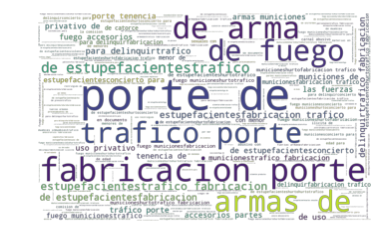

In [281]:
word_cloud_text = ''.join(inmate.delito)
wordcloud = WordCloud(
    #max_font_size=50,
    min_font_size=2,
    max_words=260,
    background_color=None,
    stopwords=noise_words,
    mode='RGBA',
    relative_scaling=0.5,
    width=800,
    height=500,
    collocations=True, #incluir bigrams
    repeat=False
).generate(word_cloud_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [411]:
# wordcloud for primary type define by TITULO
def wordcloud_crime(df,top):
    list_df=[]
    for titulo in top:
        df_filter = df[df["TITULO_DELITO"]==titulo]
        list_df.append(df_filter)
    df_filter2 = pd.concat(list_df)
    text = ' '.join(df_filter2['DELITO'])
    wordcloud = WordCloud(
        max_font_size=50,
        min_font_size=1,
        max_words=260,
        background_color=None,
        stopwords=noise_words,
        mode='RGBA',
        relative_scaling=0.1,
        width=800,
        height=500,
        collocations=False, #incluir bigrams
        repeat=False
    ).generate(text)
    grouped_color_func = GroupedColorFunc(color_to_words={'#FFAB00':top10_words}, default_color='grey')
    wordcloud.recolor(color_func=grouped_color_func)
    wordcloud.to_file("prueba.png")
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

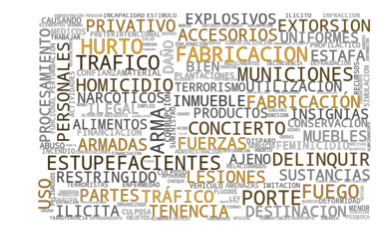

In [420]:
top=['CONTRA EL PATRIMONIO ECONOMICO', 'CONTRA LA SEGURIDAD PUBLICA',
       'CONTRA LA SALUD PUBLICA', 'CONTRA LA VIDA Y LA INTEGRIDAD PERSONAL']
wordcloud_crime( inmate, top )

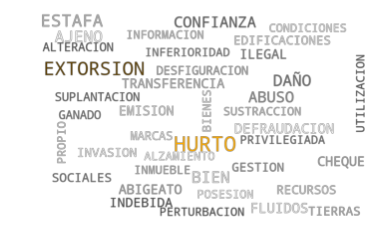

In [415]:
top1=['CONTRA EL PATRIMONIO ECONOMICO']
wordcloud_crime( inmate, top1 )

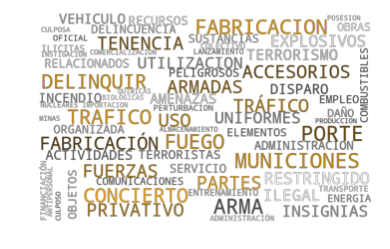

In [416]:
top2=['CONTRA LA SEGURIDAD PUBLICA']
wordcloud_crime( inmate, top2 )

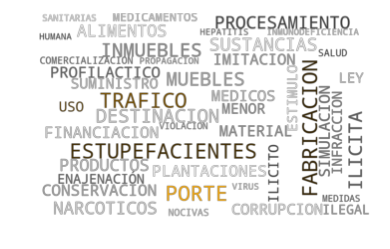

In [417]:
top3=['CONTRA LA SALUD PUBLICA']
wordcloud_crime( inmate, top3 )

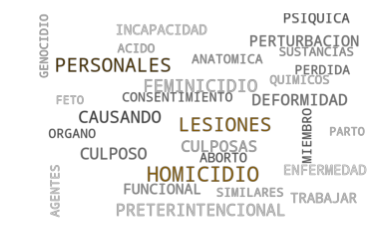

In [418]:
top4=['CONTRA LA VIDA Y LA INTEGRIDAD PERSONAL']
wordcloud_crime( inmate, top4 )

In [ ]:
#wordcloud.to_svg("prueba.svg")

In [289]:
list_word_top10 =[]
for i in top10:
    words_top10 = nltk.word_tokenize(i) 
    list_word_top10.append(words_top10)
list_word_top10 
flattened = [val for sublist in list_word_top10 for val in sublist]
top10_words = list(dict.fromkeys(flattened))
print(top10_words)

['HURTO', 'TRAFICO', 'FABRICACION', 'O', 'PORTE', 'DE', 'ESTUPEFACIENTES', 'Y', 'ARMAS', 'FUEGO', 'MUNICIONES', 'CONCIERTO', 'PARA', 'DELINQUIR', 'HOMICIDIO', 'EXTORSION', 'FABRICACIÓN', ',', 'TRÁFICO', 'TENENCIA', 'ACCESORIOS', 'PARTES', 'VIOLENCIA', 'INTRAFAMILIAR', 'LESIONES', 'PERSONALES', 'USO', 'PRIVATIVO', 'LAS', 'FUERZAS', 'ARMADAS']


In [307]:
word_tokens = nltk.word_tokenize(''.join(top10))
bigram = ngrams(word_tokens, 2) #ngrams(word_tokens,n) gives the n-grams.
bigram

<generator object ngrams at 0x7fb83bdae938>

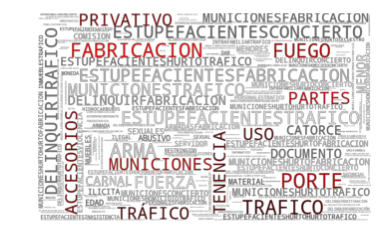

In [424]:
word_cloud_text = ''.join(inmate.DELITO)
wordcloud = WordCloud(
    max_font_size=50,
    min_font_size=1,
    max_words=260,
    background_color=None,
    stopwords=noise_words,
    mode='RGBA',
    relative_scaling=0.1,
    width=800,
    height=500,
    collocations=False, #incluir bigrams
    repeat=True
).generate(word_cloud_text)
grouped_color_func = GroupedColorFunc(color_to_words={'red':top10_words}, default_color='#ffffff')
wordcloud.recolor(color_func=grouped_color_func)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [351]:
wordcloud.to_file("prueba.png")